# 1. INTRODUCTION
In this notebook we have built the a XGBoost Model and tuned the hyperparameters using GridSearch.
We will start off by loading the necessary Python libraries.

In [37]:
import numpy as np # linear algebra
import pandas as pd
import re
import string #for removing punctuations
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pickle, itertools
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# 2. Load and  Prepare Data
Then load the Train and Test data. 

In [9]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


In our Data Analysis phase, we saw that the Text feature of Train and Test need to be cleaned, before using them. So, the below code cleans the Text feature.

In [10]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_punct(text):
    table=str.maketrans('','', string.punctuation)
    return text.translate(table)

df_train['text'] = df_train['text'].apply(lambda x: remove_url(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_url(x))

df_train['text'] = df_train['text'].apply(lambda x: remove_html(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_html(x))

df_train['text'] = df_train['text'].apply(lambda x: remove_emoji(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_emoji(x))

df_train['text'] = df_train['text'].apply(lambda x: remove_punct(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_punct(x))

df_train['text'] = df_train['text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
df_test['text'] = df_test['text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply(lambda x: x.lower())


# 3. word embedding- transformation from words to vectors.
The challenge with textual data is that it needs to be represented in a format that can be mathematically used in solving some problem.
In simple words, we need to get an integer representation of a word. 

One of the most commonly used technique to vectorize text by computing **TD-IDF**. Let us first cover the theoretical part of this before implementing this.

TF-IDF stands for **term frequency-inverse document frequency** which assigns weights to the word based on the number of occurrences in the document and even takes into consideration the frequency of the word in all the documents. TF-IDF is an acronym that stands for “Term Frequency – Inverse Document” Frequency which is a product of the below scores assigned to each word.

1. **Term Frequency**: This summarizes how often a given word appears within a document.
   $$TF(t) = (Number_of_times_term_t_appears_in_a_document) / (Total_number_of_terms_in_the_document)$$
2. **Inverse Document Frequency**: This downscales words that appear a lot across documents.
   $$IDF(t) = log_e(Total_number_of_documents / Number_of_documents_with_term_t_in_it$$

This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. 

The scores are normalized to values between 0 and 1 and the encoded document vectors can then be used directly with most machine learning algorithms. This approach is better than BOW(Bag of Words) which just counts the occurrences of words because TF-IDF lowers the weight of the words that occur too often in all the sentences like ‘a’, ‘the’, ‘as’ etc and increases the weight of the words that can be important in a sentence.
This is useful in the scenarios where we want to get the important words from all the documents and is commonly used in topic modelling.

The logic of the below piece of code is explained here.
1. Tokenize the each english sentence in "Text" feature of Train into seperate words.
<br><br>
2. Use python impelementation of **Word2Vec** from **gensim** library  to generate vector representations of words that carry semantic meanings for further NLP tasks. Each word vector is typically represented using several hundred dimensions and each unique word in the  our Train(also called corpus) is assigned a vector in the space.
Below is the list of Hyperparameters for Word2Vec chosen:<br>
    **'size'** which is dimensions of word embeddings = 50<br>
    **'min_count'** which indicate the all the words with frequncey less than this value = 5<br>
    **'workers'** which indicates worker threads to train the model = 4<br>
<br>
4. Calculate TF-IDF . Following is the list of hyperparameters of TF-IDF chosen:<br>
    **'max_features'** build a vocabulary that only consider the top max_features ordered by term frequency across the corpus =2500 <br> 
    **'min_df'** hich indicates to ignore terms that have frequency strictly lower than the given threshold=7 <br>
    **'max_df'** which indicates to ignore terms that have frequency strictly higher than the given threshold = 0.8 <br>
<br>
5. Loop through every text Feature in Train to multiply its' TF-IDF value with its word2Vec weight.      

We do the above steps for Test as well.
Finally, split Train into Train and Val in the ratio 80:20 

In [11]:
list_of_sent_train = []
list_of_sent_test = []

for i in range(0, df_train.shape[0]):
    tweet = df_train['text'][i]
    tweet = tweet.split()
    list_of_sent_train.append(tweet)

for i in range(0, df_test.shape[0]):
    tweet = df_test['text'][i]
    tweet = tweet.split()
    list_of_sent_test.append(tweet)

w2v_model_train = gensim.models.Word2Vec(list_of_sent_train, min_count=5, size=50, workers=4)
w2v_words1 = list(w2v_model_train.wv.vocab)

model1 = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8)
tf_idf_matrix = model1.fit_transform(df_train['text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model1.get_feature_names(), list(model1.idf_)))
tfidf_sent_vectors = [];  # the tfidf-w2v for each sentence/review is stored in this list
row = 0;
for sent in list_of_sent_train:  # for each review/sentence
    sent_vec = np.zeros(50)  # as word vectors are of zero length
    weight_sum = 0;  # num of words with a valid vector in the sentence/review
    for word in sent:  # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word] * (sent.count(word) / len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

X_train = tfidf_sent_vectors
X_train = np.nan_to_num(X_train)
y = df_train['target']


w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)
w2v_words2 = list(w2v_model_test.wv.vocab)

model2 = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8)
tf_idf_matrix = model2.fit_transform(df_test['text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model2.get_feature_names(), list(model2.idf_)))

tfidf_sent_vectors_test = [];  # the tfidf-w2v for each sentence/review is stored in this list
row = 0;
for sent in list_of_sent_test:  # for each review/sentence
    sent_vec = np.zeros(50)  # as word vectors are of zero length
    weight_sum = 0;  # num of words with a valid vector in the sentence/review
    for word in sent:  # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word] * (sent.count(word) / len(sent))

            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

x_test = tfidf_sent_vectors_test
x_test = np.nan_to_num(x_test)
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y, stratify=df_train['target'], test_size=0.2,
                                              random_state=42)

In [41]:
parameters = {'learning_rate': [0.1, 0.15],
              'max_depth': [7,8,9],
              'min_child_weight': [14,15,16],
              'subsample': [0.9,0.99],
              'n_estimators': [150,200,210, 1000],
              'gamma': [0.05, 0.059],
              'alpha': [6,7],
              }
model = XGBClassifier(objective = "binary:logistic")
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1001)

clf = RandomizedSearchCV(model, parameters, n_jobs=5,
                   cv=5,
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(X_tra, y_tra)

pickle.dump(clf.best_estimator_, open("./models/xgbmodel.pickle", "wb"))

print(clf.best_params_)

y_pred = clf.best_estimator_.predict(X_val)

Test_Prediction = clf.best_estimator_.predict(x_test)
sub_df = pd.DataFrame({"id": df_test["id"].values})
sub_df["target"] = Test_Prediction
sub_df.to_csv("./outputs/xgbsubmission_final.csv", index=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  5.1min finished


{'subsample': 0.99, 'n_estimators': 200, 'min_child_weight': 15, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.059, 'alpha': 6}


# Confusion Matrix and Classification Report

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


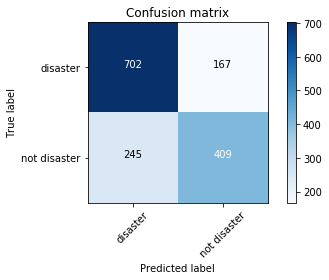

In [40]:
classes = ['disaster','not disaster']
plot_confusion_matrix(confusion_matrix(y_val, y_pred), classes)

In [42]:
print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77       869
           1       0.70      0.63      0.66       654

    accuracy                           0.72      1523
   macro avg       0.72      0.71      0.71      1523
weighted avg       0.72      0.72      0.72      1523

0.7235718975705844
